## Gradient Descent Algorithm with variations
### Gradient descent is a first-order iterative optimization algorithm for finding the minimum of a function.


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mat
import numpy as np
import pandas as pd
import seaborn as sns
import time
import sklearn as skl
import statsmodels.api as sm

from scipy import stats 
from sklearn.datasets.samples_generator import make_regression
from sklearn.datasets import make_blobs
%matplotlib inline

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mat.__version__)
print("statsmodel version:", sm.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", skl.__version__)

numpy version: 1.18.5
pandas version: 1.0.5
matplotlib version: 3.3.0
statsmodel version: 0.11.1
seaborn version: 0.10.1
sklearn version: 0.23.1


## Timer Function
### This calculates the time duration for which a given function executes.

In [3]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    ## END
    return timed
## END

## Lets create a regression dataset & plot them

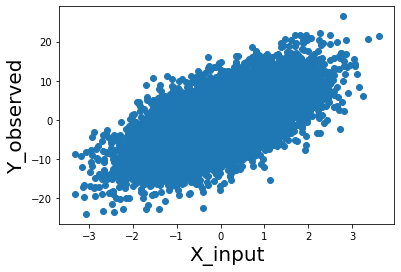

In [11]:
X, Y = make_regression(n_samples=10000, n_features=1, n_informative=1, noise=5.0, random_state=2020, shuffle=True)
plt.scatter(X,Y)
plt.xlabel('X_input', fontsize = 20)
plt.ylabel('Y_observed', fontsize = 20)
plt.show()

## Get the regression results

In [12]:
feature_matrix = sm.add_constant(X)
Y_observed = Y
result = sm.OLS(Y_observed, feature_matrix).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     7125.
Date:                Fri, 21 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:53:58   Log-Likelihood:                -30281.
No. Observations:               10000   AIC:                         6.057e+04
Df Residuals:                    9998   BIC:                         6.058e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0477      0.050     -0.954      0.340      -0.146       0.050
x1             4.2630      0.051     84.407      0.000       4.164       4.362
==============================================================================
Omnibus:                        0.760   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.776
Skew:                          -0.021   Prob(JB):                        0.678
Kurtosis:                       2.987   Cond. No.                         1.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

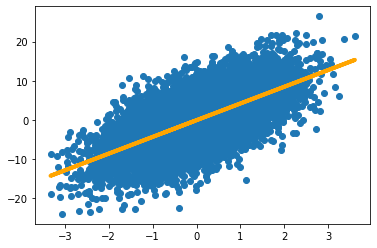

In [13]:
# slope,intercept = 94.5130,0.1003
# slope,intercept = 89.1429,0.0575
slope,intercept = 4.2630, -0.0477

plt.scatter(X, Y)
Y_predicted = slope*feature_matrix + intercept
plt.plot(feature_matrix, Y_predicted, lw = 4, c = 'orange', label = 'regression line')

## Cost Function & Gradients
The equation for calculating cost function and gradients are as shown below.  
Please note the cost function is for Linear regression.  
For other algorithms the cost function will be different and the gradients would have to be derived from the cost functions

### Cost
$$
J(\theta) = 1/2m \sum_{i=1}^{m} (h(\theta)^{(i)} - y^{(i)})^2 
$$

### Gradient
$$
\frac{\partial J(\theta)}{\partial \theta_j} = 1/m\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_j^{(i)}
$$

$$
\theta_j: = \theta_j -\alpha . (1/m .\sum_{i=1}^{m}(h(\theta^{(i)} - y^{(i)}).X_0^{(i)})
$$

## Define the cost function

In [14]:
def calculate_cost(theta,X,Y):
    m = len(Y)
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-Y))
    return cost

## Define batch gradient descent

In [15]:
@timeit
def batch_gradient_descent(X, Y, theta, alpha=0.01, iterations=100):
    m = len(Y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, 2))
    for it in range(iterations):
        prediction = np.dot(X, theta)
        theta = theta - (1 / m) * alpha * (X.T.dot((prediction - Y)))
        theta_history[it, :] = theta.T
        cost_history[it] = calculate_cost(theta, X, Y)
    return theta, cost_history, theta_history

### Let's start with 1000 iterations and a learning rate of 0.05. Start with theta from a Gaussian distribution

In [16]:
Y = Y.reshape(-1,1)
alpha = 0.05
n_iter = 1000
theta = np.random.randn(2, 1)
X_b = np.c_[np.ones((len(X), 1)), X]

theta, cost_history, theta_history = batch_gradient_descent(X_b, Y, theta, alpha, n_iter)

print("Theta0: {:0.3f}\nTheta1: {:0.3f}".format(theta[0][0], theta[1][0]))
print("Final cost/MSE:  {:0.3f}".format(cost_history[-1]))

'batch_gradient_descent'  260.29 ms
Theta0: -0.048
Theta1: 4.263
Final cost/MSE:  1249206396.709


### Let's plot the cost history over iterations

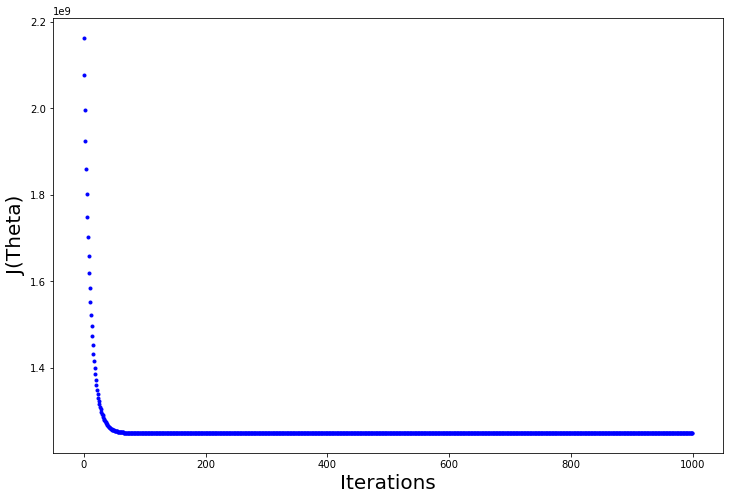

In [17]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel("J(Theta)", fontsize = 20)
ax.set_xlabel("Iterations", fontsize = 20)
_ = ax.plot(range(n_iter),cost_history,'b.')

##### After around 70 iterations the cost is flat so the remaining iterations are not needed or will not optimize any further.  
##### Let us zoom in till iteration 100 and see the curve

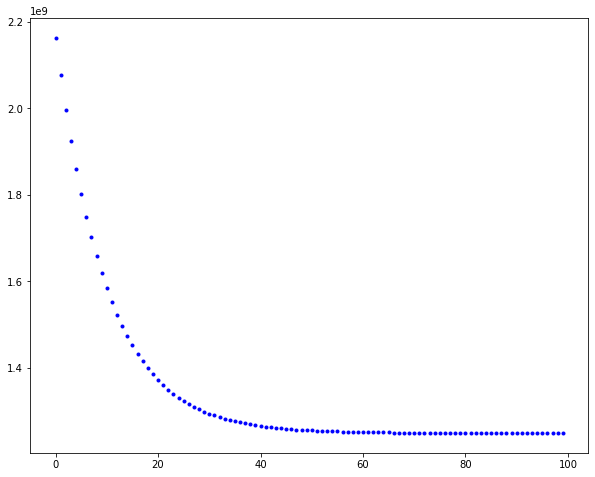

In [18]:
fig,ax = plt.subplots(figsize = (10,8))
_ = ax.plot(range(100), cost_history[:100], 'b.')

## Stochastic Gradient Descent

In [19]:
@timeit
def stocashtic_gradient_descent(X, Y, theta, alpha=0.01, iterations=10):
    m = len(Y)
    cost_history = np.zeros(iterations)
    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_ind = np.random.randint(0, m)
            X_i = X[rand_ind, :].reshape(1, X.shape[1])
            Y_i = Y[rand_ind].reshape(1, 1)
            prediction = np.dot(X_i, theta)
            theta = theta - (1 / m) * alpha * (X_i.T.dot((prediction - Y_i)))
            cost += calculate_cost(theta, X_i, Y_i)
        cost_history[it] = cost
    ## END
    return theta, cost_history
## END

In [20]:
alpha = 0.05
n_iter = 1000
theta = np.random.randn(2, 1)
X_b = np.c_[np.ones((len(X),1)),X]

theta, cost_history = stocashtic_gradient_descent(X_b, Y, theta, alpha, n_iter)

print("Theta0: {:0.3f}\nTheta1: {:0.3f}".format(theta[0][0], theta[1][0]))
print("Final cost/MSE:  {:0.3f}".format(cost_history[-1]))

'stocashtic_gradient_descent'  249129.00 ms
Theta0: -0.047
Theta1: 4.271
Final cost/MSE:  125660.396


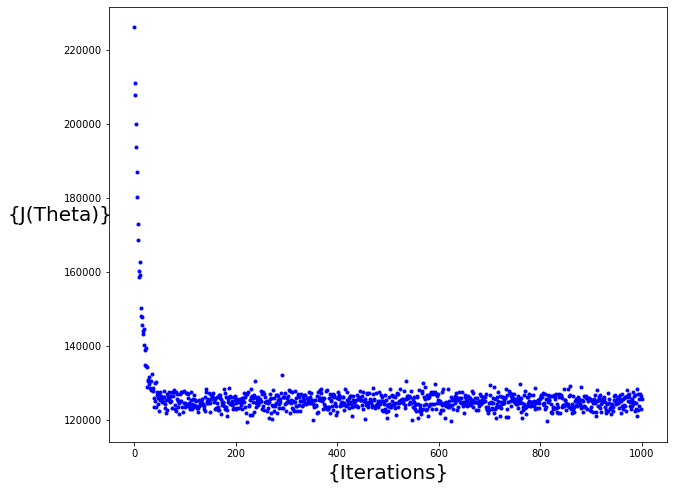

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylabel("{J(Theta)}", rotation=0, fontsize = 20)
ax.set_xlabel("{Iterations}", fontsize = 20)
theta = np.random.randn(2, 1)
_ = ax.plot(range(n_iter), cost_history, "b.")

## Mini Batch Gradient Descent

In [22]:
@timeit
def mini_batch_gradient_descent(X, Y, theta, alpha=0.01, iterations=10, batch_size =20):
    m = len(Y)
    cost_history = np.zeros(iterations)
    n_batches = int(m/batch_size)
    for it in range(iterations):
        cost =0.0
        indices = np.random.permutation(m)
        X = X[indices]
        Y = Y[indices]
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            Y_i = Y[i:i+batch_size]
            X_i = np.c_[np.ones(len(X_i)),X_i]
            prediction = np.dot(X_i,theta)
            theta = theta -(1/m)*alpha*( X_i.T.dot((prediction - Y_i)))
            cost += calculate_cost(theta,X_i,Y_i)
        cost_history[it]  = cost
    return theta, cost_history

In [23]:
alpha = 0.05
n_iter = 1000
theta = np.random.randn(2, 1)

theta,cost_history = mini_batch_gradient_descent(X, Y, theta, alpha, n_iter)

print('Theta0:          {:0.3f}\nTheta1:          {:0.3f}'.format(theta[0][0],theta[1][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

'mini_batch_gradient_descent'  56330.18 ms
Theta0:          -0.048
Theta1:          4.263
Final cost/MSE:  2498388.210


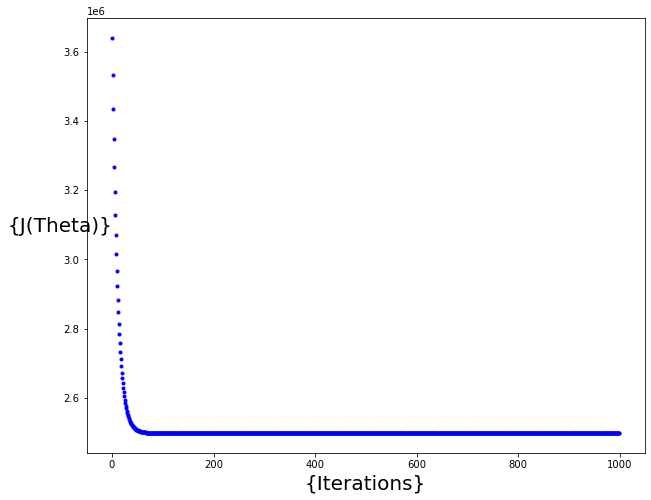

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylabel("{J(Theta)}", rotation=0, fontsize = 20)
ax.set_xlabel("{Iterations}", fontsize = 20)
theta = np.random.randn(2, 1)
_ = ax.plot(range(n_iter), cost_history, "b.")

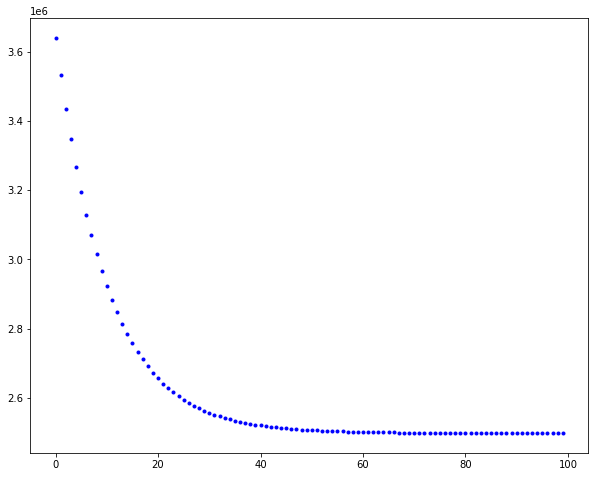

In [25]:
fig,ax = plt.subplots(figsize=(10,8))
_ = ax.plot(range(100),cost_history[:100],'b.')